### Improving Baseball Reference's Pitcher War with Outs Above Average
Baseball Reference's pitching WAR calculates a pitcher's value by looking at the pitcher's runs allowed, then adjusting for team defense, opponents faced, and park factors. The problem with this approach is that this team defense factor does not take into account a team's performance for a particular pitcher - the same factor is used for all players on a team. This is problematic, because certain players will benefit more or be hindered more by their team's defense based on their batted ball profile, luck, etc.

One way to fix this issue is to used Fangraphs' WAR, which looks only at FIP (plus popups), however, this largely discounts any ability of a player to manage contact. While on the whole this works well, it is clear from Statcast data that some players manage contact better than others.

Statcast's Outs Above Average metric enables us to find a better defensive adjustment for pitchers in order to more accurately assess their value over a season. Here we use the runs prevented for a given pitcher according to OAA as this defensive adjustment and then assess how our new WAR leaderboard differs from the old one.

For more information, please see my Fangraphs community article:
https://community.fangraphs.com/fixing-baseball-references-defensive-adjustment-for-pitcher-war

In [2]:
import pandas as pd
import numpy as np

In [4]:
pitcher_val = pd.read_csv('../data/2022_value_pitching.csv')

In [13]:
pitcher_val.rename({'Name-additional':'ID'}, axis=1, inplace=True)

In [11]:
pitcher_val[['Name','is_qualified']] = pitcher_val['Name'].str.split('*',expand=True)

In [14]:
pitcher_val

,Rk,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,...,gmLI,WAAadj,WAR,RAR,waaWL%,162WL%,Salary,Acquired,ID,is_qualified
0,1,Cory Abbott,26,WSN,48.0,16,9,30,5.63,4.74,...,0.11,0.0,0.0,0,0.470,0.497,NaN,Waivers,abbotco01,None
1,2,Albert Abreu,26,3TM,38.2,33,0,15,3.49,4.34,...,0.60,-0.1,0.3,4,0.502,0.500,NaN,Traded,abreual01,None
2,3,Bryan Abreu,25,HOU,60.1,55,0,16,2.39,4.20,...,0.93,-0.2,1.3,13,0.517,0.506,NaN,Amateur Free Agent,abreubr01,None
3,4,Domingo Acevedo,28,OAK,67.2,70,0,26,3.46,4.34,...,1.43,0.0,1.2,11,0.508,0.504,NaN,Free Agency,acevedo01,None
4,5,Jason Adam,30,TBR,63.1,67,0,12,1.71,4.37,...,1.58,0.3,2.7,21,0.525,0.511,$900000,Free Agency,adamja01,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,867,Aneurys Zabala,25,MIA,2.2,2,0,0,0.00,3.95,...,0.16,-0.1,0.1,1,0.558,0.501,NaN,Free Agency,zabalan01,None
867,868,Rob Zastryzny,30,2TM,4.0,6,0,4,9.00,4.60,...,0.61,0.0,-0.2,-2,0.463,0.499,NaN,Waivers,zastrro01,
868,869,Angel Zerpa,22,KCR,11.0,3,2,3,2.45,4.25,...,1.22,0.0,0.5,4,0.618,0.502,NaN,Amateur Free Agent,zerpaan01,
869,870,T.J. Zeuch,26,CIN,10.2,3,3,18,15.19,4.93,...,NaN,0.0,-0.8,-10,0.220,0.495,NaN,NaN,zeuchtj01,None


In [15]:
pitcher_oaa = pd.read_csv('../data/outs_above_average.csv')

In [16]:
pitcher_oaa.columns

Index(['last_name', ' first_name', 'player_id', 'display_team_name', 'year',
       'primary_pos_formatted', 'fielding_runs_prevented',
       'outs_above_average', 'outs_above_average_infront',
       'outs_above_average_lateral_toward3bline',
       'outs_above_average_lateral_toward1bline', 'outs_above_average_behind',
       'outs_above_average_rhh', 'outs_above_average_lhh',
       'actual_success_rate_formatted', 'adj_estimated_success_rate_formatted',
       'diff_success_rate_formatted'],
      dtype='object')

In [21]:
pitcher_oaa = pitcher_oaa.loc[pitcher_oaa.year==2022]

In [22]:
pitcher_fwar = pd.read_csv('../data/fwar_2022.csv')

In [23]:
pitcher_fwar.columns

Index(['Name', 'Team', 'W', 'L', 'SV', 'G', 'GS', 'IP', 'K/9', 'BB/9', 'HR/9',
       'BABIP', 'LOB%', 'GB%', 'HR/FB', 'vFA (pi)', 'ERA', 'xERA', 'FIP',
       'xFIP', 'WAR', 'playerid', 'mlbamid'],
      dtype='object')

In [24]:
pitcher_oaa.columns

Index(['last_name', ' first_name', 'player_id', 'display_team_name', 'year',
       'primary_pos_formatted', 'fielding_runs_prevented',
       'outs_above_average', 'outs_above_average_infront',
       'outs_above_average_lateral_toward3bline',
       'outs_above_average_lateral_toward1bline', 'outs_above_average_behind',
       'outs_above_average_rhh', 'outs_above_average_lhh',
       'actual_success_rate_formatted', 'adj_estimated_success_rate_formatted',
       'diff_success_rate_formatted'],
      dtype='object')

In [25]:
pitcher_oaa['full_name']= pitcher_oaa[' first_name']+' ' +pitcher_oaa['last_name']

In [28]:
pitcher_val['FRP']=0
pitcher_val['fWAR']=0.0
pitcher_val['xERA']=np.nan
pitcher_val['BABIP']=np.nan

In [29]:
names = pitcher_val['Name']

In [30]:
for i in range(len(names)):
    if len(pitcher_oaa[pitcher_oaa['full_name']==(' '+names[i])]['fielding_runs_prevented'].values)>0:
        pitcher_val.at[i,'FRP']=pitcher_oaa[pitcher_oaa['full_name']==(' '+names[i])]['fielding_runs_prevented'].values[0]
    if len(pitcher_fwar[pitcher_fwar['Name']==names[i]]['WAR'].values)>0:
        pitcher_val.at[i,'fWAR']=pitcher_fwar[pitcher_fwar['Name']==names[i]]['WAR'].values[0]
    if len(pitcher_fwar[pitcher_fwar['Name']==names[i]]['xERA'].values)>0:
        pitcher_val.at[i,'xERA']=pitcher_fwar[pitcher_fwar['Name']==names[i]]['xERA'].values[0]
    if len(pitcher_fwar[pitcher_fwar['Name']==names[i]]['BABIP'].values)>0:
        pitcher_val.at[i,'BABIP']=pitcher_fwar[pitcher_fwar['Name']==names[i]]['BABIP'].values[0]

In [32]:
pitcher_val[pitcher_val['fWAR']>3]

,Rk,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,...,waaWL%,162WL%,Salary,Acquired,ID,is_qualified,FRP,fWAR,xERA,BABIP
11,12,Sandy Alcantara,26,MIA,228.2,32,32,67,2.64,4.60,...,0.683,0.536,$3800000,Traded,alcansa01,None,3,5.7,2.92,0.262
27,28,Tyler Anderson,32,LAD,178.2,30,28,57,2.87,4.31,...,0.591,0.517,$8000000,Free Agency,anderty01,,5,4.0,3.10,0.256
73,74,Shane Bieber,27,CLE,200.0,31,31,70,3.15,4.16,...,0.561,0.512,$6000000,Amateur Draft,biebesh01,None,1,4.9,3.51,0.287
110,111,Corbin Burnes,27,MIL,202.0,33,33,73,3.25,4.42,...,0.569,0.514,$6500000,Amateur Draft,burneco01,None,1,4.6,3.08,0.259
126,127,Luis Castillo,29,2TM,150.1,25,25,56,3.35,4.38,...,0.611,0.509,$7350000,Traded,castilu02,None,3,3.7,3.31,0.275
127,128,Luis Castillo,27,DET,3.2,3,0,0,0.00,4.17,...,0.557,0.501,NaN,Free Agency,castilu03,None,3,3.7,3.31,0.275
134,135,Dylan Cease,26,CHW,184.0,32,32,55,2.69,4.24,...,0.650,0.530,NaN,Traded,ceasedy01,None,0,4.4,2.70,0.260
156,157,Alex Cobb,34,SFG,149.2,28,28,72,4.33,4.51,...,0.551,0.509,$9000000,Free Agency,cobbal01,None,-4,3.7,3.15,0.336
157,158,Gerrit Cole,31,NYY,200.2,33,33,81,3.63,4.28,...,0.523,0.505,$36000000,Free Agency,colege01,None,-2,3.3,3.31,0.268
163,164,Nestor Cortes,27,NYY,158.1,28,28,44,2.50,4.32,...,0.604,0.518,NaN,Free Agency,cortene01,,1,3.6,2.70,0.232


In [33]:
runs_to_wins = 0.109

Innings pitched needs to be converted from e.g. 10.1 to 10.333

In [37]:
pitcher_val['IP_fixed']= pitcher_val['IP']//1+(pitcher_val['IP']-pitcher_val['IP']//1)*10.0/3.0

In [41]:
pitcher_val

,Rk,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,...,162WL%,Salary,Acquired,ID,is_qualified,FRP,fWAR,xERA,BABIP,IP_fixed
0,1,Cory Abbott,26,WSN,48.0,16,9,30,5.63,4.74,...,0.497,NaN,Waivers,abbotco01,None,-1,-0.5,4.43,0.248,48.000000
1,2,Albert Abreu,26,3TM,38.2,33,0,15,3.49,4.34,...,0.500,NaN,Traded,abreual01,None,2,-0.1,4.40,0.288,38.666667
2,3,Bryan Abreu,25,HOU,60.1,55,0,16,2.39,4.20,...,0.506,NaN,Amateur Free Agent,abreubr01,None,0,1.4,2.96,0.336,60.333333
3,4,Domingo Acevedo,28,OAK,67.2,70,0,26,3.46,4.34,...,0.504,NaN,Free Agency,acevedo01,None,2,0.0,3.46,0.229,67.666667
4,5,Jason Adam,30,TBR,63.1,67,0,12,1.71,4.37,...,0.511,$900000,Free Agency,adamja01,None,-1,1.3,2.09,0.194,63.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,867,Aneurys Zabala,25,MIA,2.2,2,0,0,0.00,3.95,...,0.501,NaN,Free Agency,zabalan01,None,0,0.0,NaN,NaN,2.666667
867,868,Rob Zastryzny,30,2TM,4.0,6,0,4,9.00,4.60,...,0.499,NaN,Waivers,zastrro01,,0,0.0,NaN,NaN,4.000000
868,869,Angel Zerpa,22,KCR,11.0,3,2,3,2.45,4.25,...,0.502,NaN,Amateur Free Agent,zerpaan01,,0,-0.1,7.59,0.194,11.000000
869,870,T.J. Zeuch,26,CIN,10.2,3,3,18,15.19,4.93,...,0.495,NaN,NaN,zeuchtj01,None,-1,-0.5,8.91,0.432,10.666667


In [42]:
pitcher_val.loc[pitcher_val['Name']=='Zack Wheeler']

,Rk,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,...,162WL%,Salary,Acquired,ID,is_qualified,FRP,fWAR,xERA,BABIP,IP_fixed
836,837,Zack Wheeler,32,PHI,153.0,26,26,52,3.06,4.5,...,0.523,$26000000,Free Agency,wheelza01,None,-1,4.1,3.1,0.287,153.0


The calculation here is:

New WAR = old war + old defensive adjustment - new defensive adjustment

This just takes the old bbref WAR, removes the defensive adjustment, and replaces it with the OAA-based defensive adjustment.

The old defensive adjustment is:

runs per win * bbref defensive run adjustment * (IP/9) * park factor/100

And the new defensive adjustment:

Fielding runs prevented * runs per win * park factor/100

In [43]:
pitcher_val['new_WAR'] = pitcher_val['WAR']+runs_to_wins*pitcher_val['RA9def']*pitcher_val['IP_fixed']/900.0*pitcher_val['PPFp']-pitcher_val['FRP']*runs_to_wins*pitcher_val['PPFp']/100.0

In [44]:
pitcher_val['adj_def']=pitcher_val['RA9def']*pitcher_val['IP_fixed']/9.0

In [45]:
pitcher_val[['Name','IP','WAA','RA9def','FRP','new_WAR']]

,Name,IP,WAA,RA9def,FRP,new_WAR
0,Cory Abbott,48.0,-0.5,-0.25,-1,-0.033790
1,Albert Abreu,38.2,0.1,0.46,2,0.297398
2,Bryan Abreu,60.1,0.9,0.37,0,1.566305
3,Domingo Acevedo,67.2,0.6,-0.15,2,0.873050
4,Jason Adam,63.1,1.7,0.11,-1,2.880225
...,...,...,...,...,...,...
866,Aneurys Zabala,2.2,0.1,0.11,0,0.103535
867,Rob Zastryzny,4.0,-0.2,0.08,0,-0.196152
868,Angel Zerpa,11.0,0.4,-0.28,0,0.460646
869,T.J. Zeuch,10.2,-0.8,-0.31,-1,-0.728151


In [47]:
pitcher_val['deltaWAR']=pitcher_val['new_WAR']-pitcher_val['WAR']

In [48]:
sorted_vals = pitcher_val.sort_values('deltaWAR')

In [49]:
sorted_vals.dropna(inplace=True,subset=['RA9'])

These are the players whose value drops the most with this new WAR compared to bWAR

In [51]:
sorted_vals[['Name','adj_def','FRP','fWAR','WAR','new_WAR','deltaWAR']][:10]#[::-1]

,Name,adj_def,FRP,fWAR,WAR,new_WAR,deltaWAR
757,Ranger Suárez,-5.868148,4,0.0,2.5,1.434053,-1.065947
370,Cole Irvin,-3.418889,6,1.4,2.1,1.120567,-0.979433
839,Garrett Whitlock,0.435185,8,1.4,1.8,0.897102,-0.902898
386,James Kaprielian,-2.531111,6,0.3,1.1,0.201725,-0.898275
716,Brady Singer,-3.918519,3,2.9,4.5,3.703651,-0.796349
389,Brad Keller,-4.190000,2,0.7,0.2,-0.504397,-0.704397
205,Camilo Doval,-2.255556,4,1.2,1.9,1.209280,-0.690720
852,Alex Wood,-4.936296,1,1.7,0.3,-0.352233,-0.652233
180,Yu Darvish,2.595556,9,4.2,4.4,3.747989,-0.652011
264,Zac Gallen,5.315556,11,4.3,5.3,4.672341,-0.627659


These are the players whose value increases the most

In [52]:
sorted_vals[['Name','adj_def','FRP','fWAR','WAR','new_WAR','deltaWAR']][::-1][:10]

,Name,adj_def,FRP,fWAR,WAR,new_WAR,deltaWAR
157,Gerrit Cole,13.154815,-2,3.3,2.5,4.156830,1.656830
794,Julio Urías,9.916667,-4,0.0,4.9,6.468492,1.568492
276,Kevin Gausman,5.240000,-8,5.7,3.1,4.546046,1.446046
766,Jameson Taillon,14.777778,2,2.3,1.3,2.698349,1.398349
407,George Kirby,4.044444,-9,3.0,1.4,2.749330,1.349330
162,Patrick Corbin,-5.088889,-16,0.8,-2.4,-1.251125,1.148875
837,Mitch White,5.170000,-5,1.3,-0.7,0.428484,1.128484
163,Nestor Cortes,11.259259,1,3.6,4.3,5.418259,1.118259
616,Zach Plesac,8.046296,-2,0.9,-0.7,0.380811,1.080811
399,Clayton Kershaw,6.878148,-2,3.8,3.8,4.827717,1.027717


Here are our new WAR leaders:

In [53]:
sorted_WAR = pitcher_val.sort_values('new_WAR')

In [54]:
sorted_WAR.dropna(inplace=True,subset=['RA9'])

In [57]:
sorted_WAR[::-1][:10]

,Rk,Name,Age,Tm,IP,G,GS,R,RA9,RA9opp,...,ID,is_qualified,FRP,fWAR,xERA,BABIP,IP_fixed,new_WAR,adj_def,deltaWAR
11,12,Sandy Alcantara,26,MIA,228.2,32,32,67,2.64,4.60,...,alcansa01,None,3,5.7,2.92,0.262,228.666667,7.750942,2.540741,-0.049058
805,806,Justin Verlander,39,HOU,175.0,28,28,43,2.21,4.35,...,verlaju01,None,0,6.1,2.66,0.240,175.000000,6.606444,8.555556,0.906444
467,468,Alek Manoah,24,TOR,196.2,31,31,55,2.52,4.25,...,manoaal01,None,1,4.1,3.31,0.244,196.666667,6.531964,5.900000,0.531964
794,795,Julio Urías,25,LAD,175.0,31,31,51,2.62,4.35,...,uriasju01,,-4,0.0,NaN,NaN,175.000000,6.468492,9.916667,1.568492
258,259,Max Fried,28,ATL,185.1,30,30,55,2.67,4.46,...,friedma01,,0,5.0,2.85,0.280,185.333333,6.328178,3.912593,0.428178
134,135,Dylan Cease,26,CHW,184.0,32,32,55,2.69,4.24,...,ceasedy01,None,0,4.4,2.70,0.260,184.000000,6.128041,-2.453333,-0.271959
572,573,Shohei Ohtani,27,LAA,166.0,28,28,45,2.44,4.31,...,ohtansh01,None,5,5.6,2.68,0.289,166.000000,5.805463,1.475556,-0.394537
564,565,Aaron Nola,29,PHI,205.0,32,32,75,3.29,4.47,...,nolaaa01,None,-5,6.3,2.74,0.289,205.000000,5.702765,-6.833333,-0.197235
163,164,Nestor Cortes,27,NYY,158.1,28,28,44,2.50,4.32,...,cortene01,,1,3.6,2.70,0.232,158.333333,5.418259,11.259259,1.118259
693,694,Max Scherzer,37,NYM,145.1,23,23,39,2.42,4.56,...,scherma01,None,-1,4.4,2.87,0.276,145.333333,5.286554,-0.161481,0.086554


In [58]:
import matplotlib.pyplot as plt

In [59]:
pitcher_val.dropna(inplace=True,subset=['xERA'])

Text(0, 0.5, 'new bWAR')

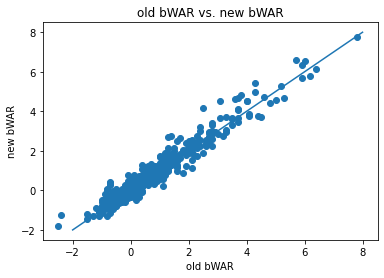

In [62]:
plt.scatter(pitcher_val['WAR'].to_numpy(),pitcher_val['new_WAR'].to_numpy())
plt.plot([-2,8],[-2,8])
plt.title('old bWAR vs. new bWAR')
plt.xlabel('old bWAR')
plt.ylabel('new bWAR')

Text(0, 0.5, 'old bWAR')

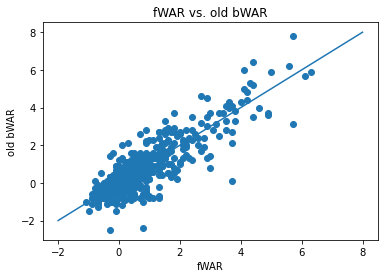

In [65]:
plt.scatter(pitcher_val['fWAR'].to_numpy(), pitcher_val['WAR'].to_numpy())
plt.plot([-2,8],[-2,8])
plt.title('fWAR vs. old bWAR')
plt.xlabel('fWAR')
plt.ylabel('old bWAR')

Text(0, 0.5, 'new bWAR')

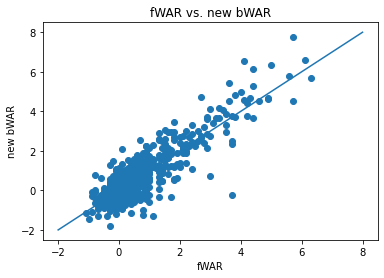

In [66]:
plt.scatter(pitcher_val['fWAR'].to_numpy(),pitcher_val['new_WAR'].to_numpy())
plt.plot([-2,8],[-2,8])
plt.title('fWAR vs. new bWAR')
plt.xlabel('fWAR')
plt.ylabel('new bWAR')

Here are some Pearson correlation coefficients among these different versions of WAR:

In [67]:
pitcher_val['WAR'].corr(pitcher_val['fWAR'])

0.8477699431096901

In [68]:
pitcher_val['WAR'].corr(pitcher_val['new_WAR'])

0.9715174544074099

In [69]:
pitcher_val['new_WAR'].corr(pitcher_val['fWAR'])

0.8728983026007651

We see that our new bWAR correlates a bit more closely to fWAR than the old bWAR does. However, because this includes pitchers with very few innings pitched, it makes sense to use an inning cutoff. Here we'll use 40 innings (arbitrarily).

In [72]:
pitcher_val_min_40 = pitcher_val.loc[pitcher_val.IP.ge(40)]

In [73]:
pitcher_val_min_40['WAR'].corr(pitcher_val_min_40['fWAR'])

0.8351474524925491

In [74]:
pitcher_val_min_40['WAR'].corr(pitcher_val_min_40['new_WAR'])

0.9674515036753166

In [75]:
pitcher_val_min_40['new_WAR'].corr(pitcher_val_min_40['fWAR'])

0.86514711898424

In [77]:
pitcher_val.to_csv('../outputs/new_WAR_2022.csv', index=False)